# <b>Insurance</b><a id='home'></a>

1. [Import Data and Packages](#import)
2. [Prepare Data](#prepare)
3. [Exploratory Data Analysis](#exploratory)
4. [Find Similar Customers](#knn)
5. [Predict Customers Recieving Benefits](#knn_class)
6. [K Nearest Neighbors Regression](#knn_regress)
7. [Transform Data](#transform)
8. [Conclusion and Business Application](#conclusion)


## <b>Import Packages and Data</b><a id='import'></a>

In [1]:
# Import Packages
import numpy as np 
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

In [2]:
# Read data
try:
    insure = pd.read_csv('/Users/kellyshreeve/Desktop/Data-Sets/insurance_us.csv')
except:
    insure = pd.read_csv('/datasets/insurance_us.csv')

In [3]:
# Print info
print(insure.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Gender              5000 non-null   int64  
 1   Age                 5000 non-null   float64
 2   Salary              5000 non-null   float64
 3   Family members      5000 non-null   int64  
 4   Insurance benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB
None


There are 5000 rows in the dataset and no missing values. All data types are correct.

In [4]:
# Print head
display(insure.head(10))

,Gender,Age,Salary,Family members,Insurance benefits
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0
5,1,43.0,41000.0,2,1
6,1,39.0,39700.0,2,0
7,1,25.0,38600.0,4,0
8,1,36.0,49700.0,1,0
9,1,32.0,51700.0,1,0


### Read data conclusions

This analysis has one dataset containing 5 columns and 5000 rows. Columns represent insurance clients' gender, age, salary, number of family members, and insurance benefits. Column names need to be changed to snake case. There are no missing values.

[back to top](#home)

## <b>Prepare Data</b><a id='prepare'></a>

Column names are changed to snake case, dataset is checked for duplicates, and a binary filed claim feature is added.

### Fix columns names

In [5]:
# Change columns to snake case
insure.columns = insure.columns.str.lower().str.replace(' ', '_')

print(insure.columns)

Index(['gender', 'age', 'salary', 'family_members', 'insurance_benefits'], dtype='object')


Columns are converted to snake case.

### Check for Duplicates

In [6]:
# Check for full duplicates
num_duplicates = insure.duplicated().sum()

print(f'The number of fully duplicated rows: {num_duplicates}')

The number of fully duplicated rows: 153


While there are duplicated rows, this is likely due to multiple people sharing the same gender, age, salary, family members, and insurance benefits. These duplicates will be left in the dataset.

### Add additional Features

In [7]:
# Add binary filed claim variable where
# 0 = filed no claims and 1 = filed at least one claime
insure['recieved_benefit'] = np.where(insure['insurance_benefits'] > 0, 1, 0)

display(insure.head())

,gender,age,salary,family_members,insurance_benefits,recieved_benefit
0,1,41.0,49600.0,1,0,0
1,0,46.0,38000.0,1,1,1
2,0,29.0,21000.0,0,0,0
3,0,21.0,41700.0,2,0,0
4,1,28.0,26100.0,0,0,0


### Prepare data conclusions

Variable names are snake case, duplicates have been explored, and a binary filed claim feature is added. The data is ready for analysis.

### <b>Exploratory Data Analysis</b><a id='exploratory'></a>

Distributions of each feature are explored.

array([[<Axes: xlabel='age', ylabel='age'>,
        <Axes: xlabel='salary', ylabel='age'>,
        <Axes: xlabel='family_members', ylabel='age'>,
        <Axes: xlabel='insurance_benefits', ylabel='age'>],
       [<Axes: xlabel='age', ylabel='salary'>,
        <Axes: xlabel='salary', ylabel='salary'>,
        <Axes: xlabel='family_members', ylabel='salary'>,
        <Axes: xlabel='insurance_benefits', ylabel='salary'>],
       [<Axes: xlabel='age', ylabel='family_members'>,
        <Axes: xlabel='salary', ylabel='family_members'>,
        <Axes: xlabel='family_members', ylabel='family_members'>,
        <Axes: xlabel='insurance_benefits', ylabel='family_members'>],
       [<Axes: xlabel='age', ylabel='insurance_benefits'>,
        <Axes: xlabel='salary', ylabel='insurance_benefits'>,
        <Axes: xlabel='family_members', ylabel='insurance_benefits'>,
        <Axes: xlabel='insurance_benefits', ylabel='insurance_benefits'>]],
      dtype=object)

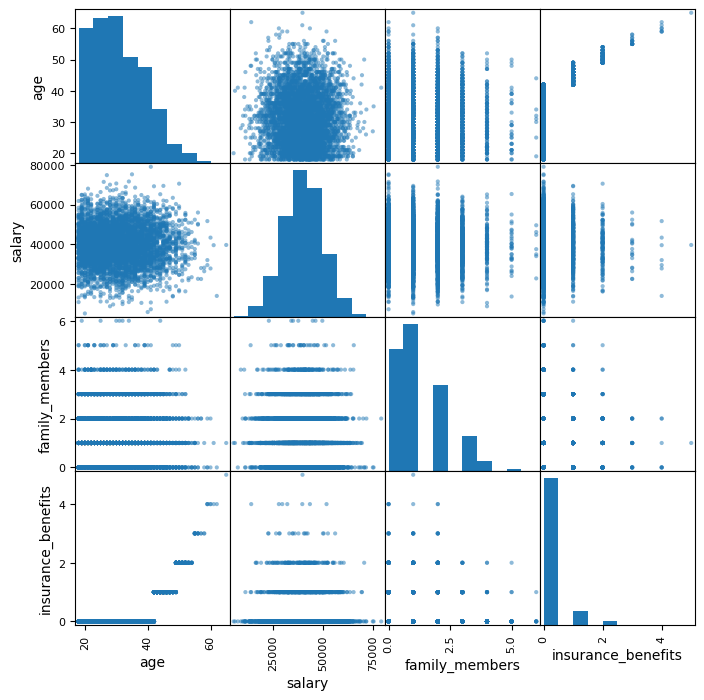

In [8]:
# Scatter matrix for age, salary, family members, and insurance benefits
pd.plotting.scatter_matrix(insure.iloc[:, 1:5], alpha=0.5, figsize=(8, 8))

While salary appears normally distributed, age, family members, and insurance benefits are highly right skewed. There is a non-linear relationship between insurance benefits and age, salary, and family members. Assumptions of a linear regression appear violated, making this dataset a good candidate for non-parametric models.

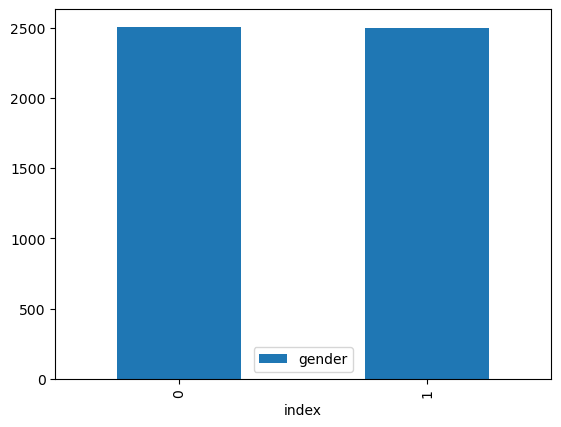

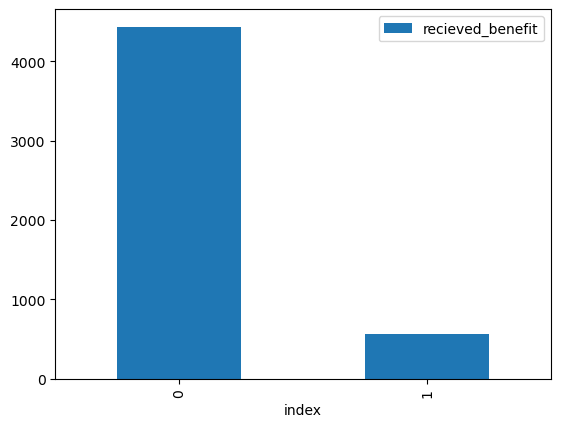

In [9]:
# Bar graphs of gender and filed claim
columns = ['gender', 'recieved_benefit']

for column in columns:
    insure[column].value_counts().reset_index().plot.bar(x='index', y=[column])

There are similar numbers of men and women in the dataset. Far more people didn't recieve a benefit than did, making predictions for the binary recieved benefit variable a good candidate for either imbalanced classification or non-parametric models.

In [10]:
# Frequency/Rel Freq/Cum Rel Feq table of gender, family members,
# total insurance benefits, and filed claim
columns = ['gender', 'family_members', 'insurance_benefits', 'recieved_benefit']

for column in columns:
    freq_table = insure[column].value_counts().sort_index().reset_index()

    freq_table['Relative Frequency'] = (insure[column]
                                             .value_counts(normalize=True)
                                             .sort_index()
                                             .values)

    freq_table['Cumulative Frequency'] = (insure[column]
                                               .value_counts(normalize=True)
                                               .sort_index()
                                               .cumsum().values)

    freq_table = freq_table.rename(columns={'index':'Claims Number',
                                            column:'Frequency'})
                                   
    print(f'Frequency Table {column}:')
    display(freq_table)


Frequency Table gender:


,Claims Number,Frequency,Relative Frequency,Cumulative Frequency
0,0,2505,0.501,0.501
1,1,2495,0.499,1.000


Frequency Table family_members:


,Claims Number,Frequency,Relative Frequency,Cumulative Frequency
0,0,1513,0.3026,0.3026
1,1,1814,0.3628,0.6654
2,2,1071,0.2142,0.8796
3,3,439,0.0878,0.9674
4,4,124,0.0248,0.9922
5,5,32,0.0064,0.9986
6,6,7,0.0014,1.0000


Frequency Table insurance_benefits:


,Claims Number,Frequency,Relative Frequency,Cumulative Frequency
0,0,4436,0.8872,0.8872
1,1,423,0.0846,0.9718
2,2,115,0.0230,0.9948
3,3,18,0.0036,0.9984
4,4,7,0.0014,0.9998
5,5,1,0.0002,1.0000


Frequency Table recieved_benefit:


,Claims Number,Frequency,Relative Frequency,Cumulative Frequency
0,0,4436,0.8872,0.8872
1,1,564,0.1128,1.0000


There are almost equal numbers of men and women in the dataset. Of customers in this dataset, the most common number of family members is one with 36.38% having one family member, followed by 30.26% having no family members. Only 3.26% of customers have 4 or more family members.  88.72% recieved no insurance benefits, while only 8.46% recieved one benefit, and 2.82% recieved two or more benefits. Similarly, 88.72% of customers recieved no benefit vs 11.28% recieved at least one benefit. This is an imbalanced classification problem.

### Exploratory Data Analysis Conclusion

Age, family members, and insurance benefits are all highly right skewed variables, and there is a non-linear relationship betweeen insurance benefits and age and family members. Some of the categories in family members and insurance benefits have very few observations. The large violations in parametric assumptions make this dataset a good candidate for non-parametric models. The analysis will proceed with K Nearest Neighbors.

[back to top](#home)

## <b>Find Similar Customers</b><a id='knn'></a>

Use K Nearest Neighbors to find customers similar to a given customer.

In [11]:
# Initiate Nearest Neighbors Class to find closest 5 customers
knn_neighbors = NearestNeighbors(n_neighbors=5)

# Fit model on full data set
knn_neighbors.fit(insure)

# Test model on my characteristics
print(knn_neighbors.kneighbors([[0, 29, 60000, 1, 0, 0]]))

(array([[  7.14142843, 100.0099995 , 100.01499888, 100.01499888,
        100.019998  ]]), array([[3520, 1555, 1742, 1418, 2239]]))


/Users/kellyshreeve/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


## <b>Predict Customers Recieving Benefits</b><a id='knn_class'></a>

Fit and tune K Nearest Neighbors Classifier, Logistic Regression, and Random Forest Classification models to determine which model maximizes F1 Score. Imbalanced classes are upsampled for KNN using SMOTE and weighted for Logistic Regression and Random Forest Classification models.

In [12]:
# Define features and target
features = insure.drop(['insurance_benefits', 'recieved_benefit'], axis=1)
target_class = insure['recieved_benefit']

print('Features:')
display(features.head())
print()

print('Target:')
display(target_class.head().to_frame())

Features:


,gender,age,salary,family_members
0,1,41.0,49600.0,1
1,0,46.0,38000.0,1
2,0,29.0,21000.0,0
3,0,21.0,41700.0,2
4,1,28.0,26100.0,0



Target:


,recieved_benefit
0,0
1,1
2,0
3,0
4,0


In [16]:
# Split data into training and test
features_train, features_test, target_train_class, target_test_class = train_test_split(features, target_class,
                                                                            test_size=0.20, random_state=123)

features_train, features_val, target_train_class, target_val_class = train_test_split(features_train, target_train_class,
                                                                            test_size=0.25, random_state=123)

print(features_train.shape)
print(target_train_class.shape)

print(features_val.shape)
print(target_val_class.shape)

print(features_test.shape)
print(target_test_class.shape)

(3000, 4)
(3000,)
(1000, 4)
(1000,)
(1000, 4)
(1000,)


In [17]:
# Scale features
scaler = StandardScaler()

scaler.fit(features_train.iloc[:, 1:4])

scaler.transform(features_train.iloc[:, 1:4])
scaler.transform(features_val.iloc[:, 1:4])
scaler.transform(features_test.iloc[:, 1:4])

array([[-0.23380412, -0.05200659, -1.09479445],
       [ 0.12062355, -0.2030422 , -0.18775679],
       [ 1.18390658,  1.42814232,  2.53335617],
       ...,
       [ 0.23876611, -0.3540778 , -1.09479445],
       [ 0.8294789 , -2.156436  , -0.18775679],
       [-0.47008924, -0.27352548, -0.18775679]])

In [ ]:
# Tune K Neighbors Classifier on train set with Cross Validation
knn_class_tune = KNeighborsClassifier()

grid = {
    'n_neighbors':np.arange(1, 25),
    'weights':['uniform', 'distance'],
    'metric':['euclidean', 'cityblock', 'minkowski'],
    'algorithm':['ball_tree','kd_tree', 'brute']
}

# Use F1 Score for imbalanced classification
knn_class_gscv = GridSearchCV(knn_class_tune, param_grid=grid, scoring='f1', cv=5)
knn_class_gscv.fit(features_train, target_train_class)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'metric': ['euclidean', 'cityblock', 'minkowski'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24]),
                         'weights': ['uniform', 'distance']},
             scoring='f1')

In [ ]:
# Print results
print(knn_class_gscv.best_params_)
print(knn_class_gscv.best_score_.round(4))

{'algorithm': 'ball_tree', 'metric': 'cityblock', 'n_neighbors': 1, 'weights': 'uniform'}
0.5682


In [ ]:
knn_class_gscv.score(features_test, target_test_class)

0.7286821705426356

In [ ]:
# SMOTE upsample minority class and re-fit
smt = SMOTE()

features_smt, target_class_smt = smt.fit_resample(features_train, target_train_class)

counts_before = target_train_class.value_counts()
counts_after = target_class_smt.value_counts()

print(counts_before)
print(counts_after)

0    3327
1     423
Name: recieved_benefit, dtype: int64
0    3327
1    3327
Name: recieved_benefit, dtype: int64


In [ ]:
# Tune K Neighbors Classifier for SMOTE Upsampled Data with Cross Validation
knn_class_tune_smt = KNeighborsClassifier()

grid = {
    'n_neighbors':np.arange(1, 25),
    'weights':['uniform', 'distance'],
    'metric':['euclidean', 'cityblock', 'minkowski'],
    'algorithm':['ball_tree','kd_tree', 'brute']
}

# Use F1 Score for imbalanced classification
knn_class_gscv_smt = GridSearchCV(knn_class_tune_smt, param_grid=grid, scoring='f1', cv=5)
knn_class_gscv_smt.fit(features_smt, target_class_smt)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'metric': ['euclidean', 'cityblock', 'minkowski'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24]),
                         'weights': ['uniform', 'distance']},
             scoring='f1')

In [ ]:
# Print results
print(knn_class_gscv_smt.best_params_)
print(knn_class_gscv_smt.best_score_.round(4))

{'algorithm': 'ball_tree', 'metric': 'cityblock', 'n_neighbors': 2, 'weights': 'distance'}
0.95


In [ ]:
knn_class_gscv_smt.score(features_test, target_test_class)

0.7272727272727273

In [ ]:
# Comine up and down sampling with SMOTEENN
smttn = SMOTEENN()

features_smttn, target_class_smttn = smttn.fit_resample(features_train, target_train_class)

counts_before = target_train_class.value_counts()
counts_after = target_class_smttn.value_counts()

print(counts_before)
print(counts_after)

0    3327
1     423
Name: recieved_benefit, dtype: int64
0    2853
1    2606
Name: recieved_benefit, dtype: int64


In [ ]:
# Tune K Neighbors Classifier for SMOTEENN Upsampled Data with Cross Validation
knn_class_tune_smttn = KNeighborsClassifier()

grid = {
    'n_neighbors':np.arange(1, 25),
    'weights':['uniform', 'distance'],
    'metric':['euclidean', 'cityblock', 'minkowski'],
    'algorithm':['ball_tree','kd_tree', 'brute']
}

# Use F1 Score for imbalanced classification
knn_class_gscv_smttn = GridSearchCV(knn_class_tune_smttn, param_grid=grid, scoring='f1', cv=5)
knn_class_gscv_smttn.fit(features_smttn, target_class_smttn)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'metric': ['euclidean', 'cityblock', 'minkowski'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24]),
                         'weights': ['uniform', 'distance']},
             scoring='f1')

In [ ]:
# Print results
print(knn_class_gscv_smttn.best_params_)
print(knn_class_gscv_smttn.best_score_.round(4))

{'algorithm': 'ball_tree', 'metric': 'cityblock', 'n_neighbors': 1, 'weights': 'uniform'}
0.9936


In [ ]:
knn_class_gscv_smttn.score(features_test, target_test_class)

0.40634920634920635

In [ ]:
# Tune Logistic Regression with Weighting and Threshold

In [ ]:
# Tune Random Forest with Weighting

In [ ]:
# Test best model with test set

## <b>K Nearest Neighbors Regression</b><a id='knn_regress'></a>

## <b>Transformation<b><a id='transform'></a>

## <b>Conclusion and Business Application</b><a id='conclusion'></a>